# **Emotion Detection - Emotion Dataset (Pretrained + Base Model + Adapter)**



### Step 1: Install & Import Dependencies

In [2]:
!pip install -q transformers==4.41.2 peft==0.11.1 accelerate==0.31.0 datasets


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, roc_curve, auc,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback, AutoConfig
)
from peft import LoraConfig, TaskType, get_peft_model

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

### Step 2: Mount Google Drive & Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

file_path = "/content/drive/MyDrive/Emotion Dataset.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df = df[['Text', 'Sentiment']].dropna()
df.head()

Mounted at /content/drive


,Text,Sentiment
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


In [5]:
total_instances = len(df)
print(f"Total instances: {total_instances}")

sentiment_counts = df['Sentiment'].value_counts()
print("Number of instances per sentiment:")
print(sentiment_counts)

Total instances: 75000
Number of instances per sentiment:
Sentiment
joy         25238
sadness     21830
anger       10218
fear         8698
love         6249
surprise     2767
Name: count, dtype: int64


### Step 3: Visualize Dataset Distribution

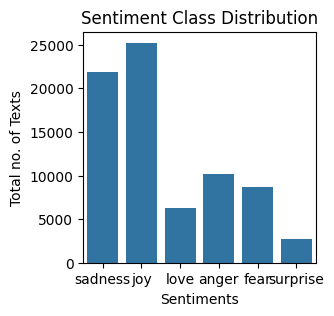

In [6]:
plt.figure(figsize=(3,3))
sns.countplot(data=df, x='Sentiment')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiments")
plt.ylabel("Total no. of Texts")
plt.grid(False)
plt.show()


### Step 4: Encode Labels

In [7]:
label_mapping = {
    "sadness": 0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}

df['label'] = df['Sentiment'].map(label_mapping)

df = df.dropna(subset=['label'])

print("Label Mapping:")
for k, v in label_mapping.items():
    print(f"{k}: {v}")


Label Mapping:
sadness: 0
joy: 1
love: 2
anger: 3
fear: 4
surprise: 5


### Step 5: Train-Test Split

In [8]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['Text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"Train size: {len(train_texts)}, Val size: {len(val_texts)}, Test size: {len(test_texts)}")

Train size: 60000, Val size: 7500, Test size: 7500


### Step 6: Tokenization

In [9]:
base_model_name = "distilbert-base-uncased"
finetuned_model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=512)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Step 7: Dataset Class

In [10]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset   = SentimentDataset(val_encodings, val_labels)
test_dataset  = SentimentDataset(test_encodings, test_labels)

### Step 8: Define Metrics Function

In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    proba = torch.softmax(torch.tensor(logits), dim=-1).numpy()

    acc = accuracy_score(labels, preds) * 100

    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    sims = []
    for i in range(len(labels)):
        true_onehot = np.zeros(proba.shape[1])
        true_onehot[labels[i]] = 1
        sims.append(cosine_similarity([true_onehot], [proba[i]])[0][0])
    similarity_score = np.mean(sims) * 100

    confidence_score = np.mean(np.max(proba, axis=1)) * 100

    return {
        "eval_Accuracy": acc,
        "eval_Precision": prec * 100,
        "eval_Recall": rec * 100,
        "eval_F1 Score": f1 * 100,
        "eval_Similarity Score": similarity_score,
        "eval_Confidence Score": confidence_score
    }


### Step 9: Evaluate Without Fine-Tuning

In [16]:
baseline_model = AutoModelForSequenceClassification.from_pretrained(finetuned_model_name)

baseline_trainer = Trainer(
    model=baseline_model,
    args=TrainingArguments(
        output_dir="./results",
        per_device_eval_batch_size=32
    ),
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

baseline_metrics = baseline_trainer.evaluate()

print("\n===== Performance of Pretrained Transformer Model =====\n")

metrics_to_show = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "Similarity Score",
    "Confidence Score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in baseline_metrics:
        print(f"{metric} is: {baseline_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {baseline_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {baseline_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {baseline_metrics.get('eval_samples_per_second', 0.0)}")


/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: usman-muhammad1471 (usman-muhammad1471-eotvos-lorand-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



===== Performance of Pretrained Transformer Model =====

Accuracy is: 93.15%
Precision is: 89.68%
Recall is: 90.10%
F1 Score is: 89.87%
Similarity Score is: 94.63%
Confidence Score is: 96.69%

===== Evaluation Details =====
Eval Loss: 0.1745
Runtime: 7.3235 sec
Samples per second: 1024.104


### Step 9.1: Confusion Matrix (Without Fine-Tuning)

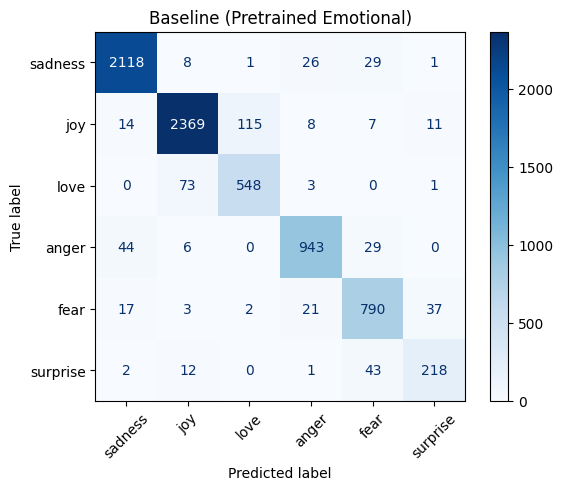

In [17]:
preds = baseline_trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)

class_names = [label for label, idx in sorted(label_mapping.items(), key=lambda x: x[1])]

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap="Blues", xticks_rotation=45)
plt.title("Baseline (Pretrained Emotional)")
plt.show()

### Step 10: Base Model Fine-Tuning Configuration & Training

In [12]:
config = AutoConfig.from_pretrained(
    base_model_name,
    num_labels=len(label_mapping),
    hidden_dropout_prob=0.4,
    attention_dropout=0.4
)

model_base = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    config=config
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    weight_decay=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="eval_F1 Score",
    greater_is_better=True,
    logging_strategy="epoch",
    report_to="none",
    fp16=True,
    gradient_accumulation_steps=2,
    save_total_limit=2,
    max_grad_norm=1.0
)

trainer_base = Trainer(
    model=model_base,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_base.train()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated.

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 score,Similarity score,Confidence score
1,0.468800,0.168231,93.120000,89.388324,91.369713,90.080693,94.593535,95.098770
2,0.159900,0.134716,93.626667,89.214270,93.391346,90.943674,95.250294,95.595917
3,0.128000,0.124718,93.520000,89.098765,92.726570,90.695296,95.488967,95.232834


TrainOutput(global_step=5625, training_loss=0.25222708875868055, metrics={'train_runtime': 655.9335, 'train_samples_per_second': 274.418, 'train_steps_per_second': 8.576, 'total_flos': 3865633029360000.0, 'train_loss': 0.25222708875868055, 'epoch': 3.0})

#### Step 10.1: Fine-Tuned Base Model Evaluation & Performance Analysis

In [13]:
finetuned_metrics = trainer_base.evaluate(test_dataset)

print("\n===== Performance after Fine-Tuning Base Model =====\n")

metrics_to_show = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "Similarity Score",
    "Confidence Score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in finetuned_metrics:
        print(f"{metric} is: {finetuned_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {finetuned_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {finetuned_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {finetuned_metrics.get('eval_samples_per_second', 0.0)}")



===== Performance after Fine-Tuning Base Model =====

Accuracy is: 93.09%
Precision is: 88.19%
Recall is: 93.01%
F1 Score is: 90.15%
Similarity Score is: 95.05%
Confidence Score is: 95.59%

===== Evaluation Details =====
Eval Loss: 0.1408
Runtime: 7.2463 sec
Samples per second: 1035.014


#### Step 10.2: Confusion Matrix Analysis

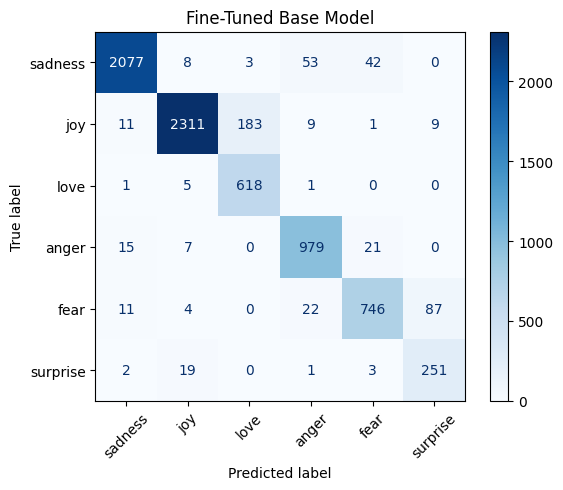

In [14]:
preds = trainer_base.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)


class_names = [label for label, idx in sorted(label_mapping.items(), key=lambda x: x[1])]

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(
    cmap="Blues",
    xticks_rotation=45
)
plt.title("Fine-Tuned Base Model")
plt.show()

#### Step 10.3: Training Progress Visualization & Loss Analysis

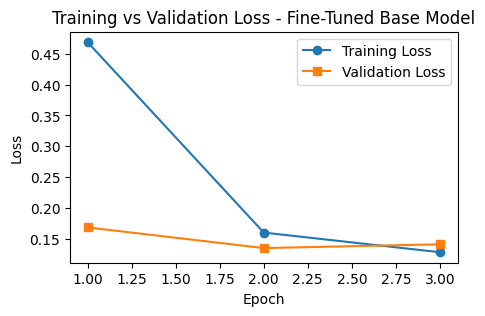

In [15]:
logs_base = trainer_base.state.log_history

train_loss_base = {}
eval_loss_base = {}

for log in logs_base:
    if "loss" in log and "epoch" in log:
        train_loss_base[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_base[float(log["epoch"])] = log["eval_loss"]

epochs_base = sorted(set(train_loss_base.keys()) | set(eval_loss_base.keys()))
train_vals_base = [train_loss_base.get(e, None) for e in epochs_base]
eval_vals_base = [eval_loss_base.get(e, None) for e in epochs_base]

# Plot
plt.figure(figsize=(5,3))
plt.plot(epochs_base, train_vals_base, label="Training Loss", marker="o")
plt.plot(epochs_base, eval_vals_base, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Fine-Tuned Base Model")
plt.legend()
plt.grid(False)
plt.show()


### Step 11: Adapter (LoRA) Model Configuration & Training

In [18]:
adapter_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=len(label_mapping)
)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.3,
    target_modules=["q_lin", "v_lin", "k_lin", "out_lin"],
    bias="none",
)

adapter_model = get_peft_model(adapter_model, peft_config)


adapter_args = TrainingArguments(
    output_dir="./results-adapter",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.1,
    warmup_ratio=0.1,
    logging_dir="./logs-adapter",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    seed=42,
    fp16=True,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    logging_steps=100,
    save_total_limit=2,
    lr_scheduler_type="cosine",
)


trainer_adapter = Trainer(
    model=adapter_model,
    args=adapter_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3),
    ]
)


print("Training model with regularization to prevent overfitting...")
trainer_adapter.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Training model with regularization to prevent overfitting...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 score,Similarity score,Confidence score
1,0.827600,0.245365,90.720000,87.270768,87.255701,87.239470,92.814586,90.679199
2,0.242000,0.154334,93.120000,88.511816,93.270664,90.462393,94.853277,94.732254
3,0.172400,0.135566,93.400000,92.527617,87.502343,89.540261,95.121148,95.865547
4,0.144000,0.116992,93.880000,92.667270,88.960681,90.181336,95.713039,95.219971
5,0.128800,0.117039,93.560000,90.901621,89.827451,90.344786,95.642402,95.453461
6,0.119000,0.110774,93.973333,90.744115,91.711983,91.071881,95.851960,95.414749
7,0.111000,0.103169,94.066667,91.243364,90.808326,90.961677,96.107074,94.972496
8,0.105600,0.104811,93.853333,90.018999,92.087504,90.979937,95.969238,95.048111
9,0.101100,0.102329,94.146667,90.797310,91.667124,91.188515,96.126477,94.885017
10,0.101600,0.102089,93.986667,90.243447,92.031028,91.091060,96.137014,94.879074


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in ver

TrainOutput(global_step=18750, training_loss=0.20531262451171875, metrics={'train_runtime': 1639.2441, 'train_samples_per_second': 366.022, 'train_steps_per_second': 11.438, 'total_flos': 1.31514106896e+16, 'train_loss': 0.20531262451171875, 'epoch': 10.0})

#### Step 11.1: Adapter (LoRA) Model Evaluation & Performance Analysis

In [20]:
adapter_metrics = trainer_adapter.evaluate(test_dataset)

print("\n===== Performance with Adapter (LoRA) =====\n")

metrics_to_show = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "Similarity Score",
    "Confidence Score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in adapter_metrics:
        print(f"{metric} is: {adapter_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {adapter_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {adapter_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {adapter_metrics.get('eval_samples_per_second', 0.0)}")



===== Performance with Adapter (LoRA) =====

Accuracy is: 93.65%
Precision is: 89.57%
Recall is: 91.24%
F1 Score is: 90.37%
Similarity Score is: 95.98%
Confidence Score is: 94.92%

===== Evaluation Details =====
Eval Loss: 0.1077
Runtime: 9.2616 sec
Samples per second: 809.793


#### Step 11.2: Confusion Matrix Analysis

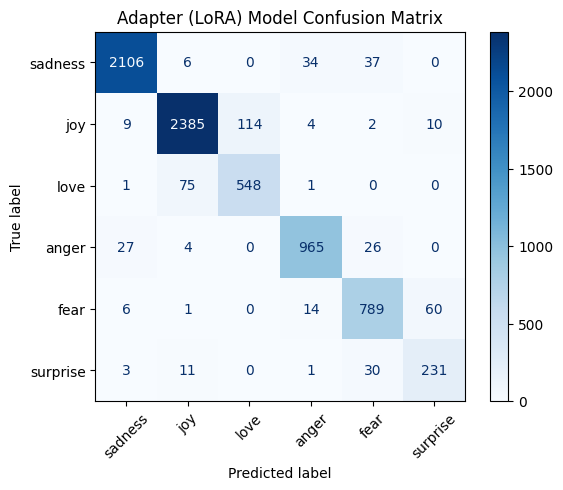

In [21]:
preds = trainer_adapter.predict(test_dataset)
y_true, y_pred = preds.label_ids, preds.predictions.argmax(-1)
cm = confusion_matrix(y_true, y_pred)
class_names = [label for label, idx in sorted(label_mapping.items(), key=lambda x: x[1])]
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap="Blues", xticks_rotation=45)
plt.title("Adapter (LoRA) Model Confusion Matrix")
plt.show()


#### Step 11.3: Training Progress Visualization & Loss Analysis

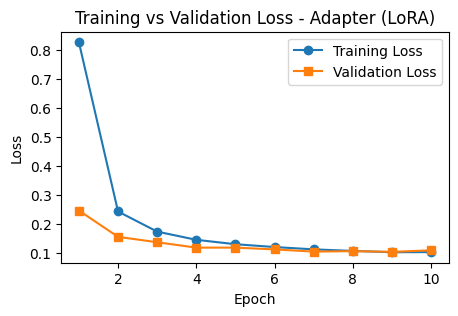

In [22]:
 logs_adapter = trainer_adapter.state.log_history

train_loss_adapter = {}
eval_loss_adapter = {}

for log in logs_adapter:
    if "loss" in log and "epoch" in log:
        train_loss_adapter[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_adapter[float(log["epoch"])] = log["eval_loss"]

epochs_adapter = sorted(set(train_loss_adapter.keys()) | set(eval_loss_adapter.keys()))
train_vals_adapter = [train_loss_adapter.get(e, None) for e in epochs_adapter]
eval_vals_adapter = [eval_loss_adapter.get(e, None) for e in epochs_adapter]

# Plot
plt.figure(figsize=(5,3))
plt.plot(epochs_adapter, train_vals_adapter, label="Training Loss", marker="o")
plt.plot(epochs_adapter, eval_vals_adapter, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Adapter (LoRA)")
plt.legend()
plt.grid(False)
plt.show()


### Step 12: Comprehensive Model Comparison & Performance Visualization

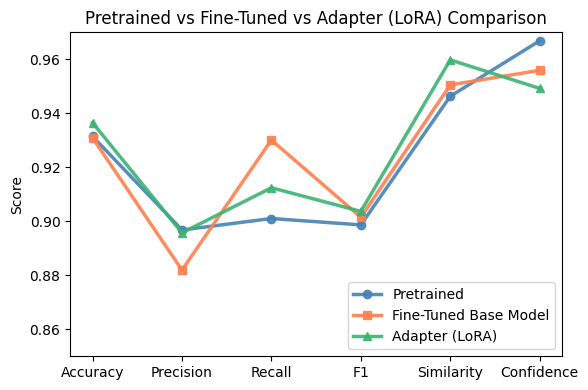

In [34]:
metrics = ["Accuracy", "Precision", "Recall", "F1", "Similarity", "Confidence"]

pretrained_vals = np.array([baseline_metrics[f"eval_{m}"] for m in ["Accuracy", "Precision", "Recall", "F1 Score", "Similarity Score", "Confidence Score"]]) / 100
base_vals = np.array([finetuned_metrics[f"eval_{m}"] for m in ["Accuracy", "Precision", "Recall", "F1 Score", "Similarity Score", "Confidence Score"]]) / 100
adapter_vals = np.array([adapter_metrics[f"eval_{m}"] for m in ["Accuracy", "Precision", "Recall", "F1 Score", "Similarity Score", "Confidence Score"]]) / 100

x = np.arange(len(metrics))

plt.figure(figsize=(6, 4))

plt.plot(x, pretrained_vals, marker='o', linestyle='-', linewidth=2.5, alpha=0.9, label="Pretrained", color='steelblue')
plt.plot(x, base_vals, marker='s', linestyle='-', linewidth=2.5, alpha=0.9, label="Fine-Tuned Base Model", color='coral')
plt.plot(x, adapter_vals, marker='^', linestyle='-', linewidth=2.5, alpha=0.9, label="Adapter (LoRA)", color='mediumseagreen')

plt.xticks(x, metrics, fontsize=10)
plt.ylabel("Score")
plt.ylim(0.85, 0.97)
plt.title("Pretrained vs Fine-Tuned vs Adapter (LoRA) Comparison")
plt.grid(False)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()